In [302]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gymnasium as gym
from IPython.display import clear_output

In [356]:
class ANN(nn.Module):

    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )

    def forward(self, x):
        x = torch.tensor(x)
        return self.layers(x)

In [384]:
class SarsaAgent:

    def __init__(self, num_observations, num_actions, num_hidden):
        self.num_actions = num_actions
        self.model = ANN(num_observations, num_hidden, num_actions)
        self.alpha = None
        self.gamma = None
        self.epsilon = None
        self.last_action = None
        self.last_obs = None

    def select_action(self, obs):
        choice = 'greedy' if np.random.random() > self.epsilon else 'epsilon'
        with torch.no_grad():
            action_values = self.model(obs)
        action = action_values.argmax().item() if choice == 'greedy' else np.random.choice(self.num_actions)
        return action
    
    def start(self, obs):
        action = self.select_action(obs)
        self.last_action = action
        self.last_obs = obs.copy()
        return action
    
    def step(self, obs, reward):
        action = self.select_action(obs)
        action_value = self.model(obs)[action]
        last_action_value = self.model(self.last_obs)[self.last_action]
        delta = reward + self.gamma * action_value - last_action_value
        last_action_value.backward()
        for p in self.model.parameters():
            p.data += self.alpha * delta * p.grad
            p.grad = None
        self.last_action = action
        self.last_obs = obs.copy()
        return action
    
    def end(self, reward):
        last_action_value = self.model(self.last_obs)[self.last_action]
        delta = reward - last_action_value
        last_action_value.backward()
        for p in self.model.parameters():
            p.data += self.alpha * delta * p.grad
            p.grad = None

In [385]:
def plot(num_steps_list):
    plt.figure(figsize=(5, 4))
    plt.plot(num_steps_list, color='royalblue')
    plt.title('SARSA for CartPole-v1')
    plt.grid(alpha=0.2)
    plt.xlabel('episode')
    plt.ylabel('num_steps')
    plt.show()

In [393]:
env = gym.make('CartPole-v1')
agent = SarsaAgent(num_observations=4, num_actions=2, num_hidden=1024)
agent.alpha = 0.001
agent.gamma = 1.0
agent.epsilon = 0.1
num_steps_list = []

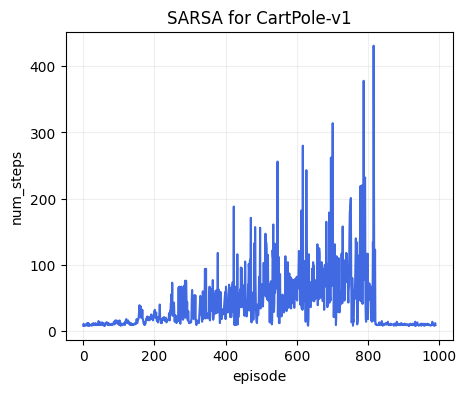

In [394]:
num_episodes = 1000
plot_episode = 10

for episode in range(num_episodes):
    obs, _ = env.reset()
    action = agent.start(obs)
    done, win = False, False
    num_steps = 0
    while not done:
        obs, reward, done, win, _ = env.step(action)
        action = agent.step(obs, reward)
        num_steps += 1
        if done or win:
            agent.end(reward)
            break
    num_steps_list.append(num_steps)
    if episode % plot_episode == 0:
        plot(num_steps_list)
        clear_output(wait=True)

In [383]:
for p in agent.model.parameters():
    print(p)

Parameter containing:
tensor([[-0.4865,  0.2692,  0.0029, -0.1417],
        [-0.0842, -0.4325,  0.2743, -0.1226],
        [ 0.0796, -0.3216,  0.0443,  0.6799],
        ...,
        [ 0.0721, -0.4867,  0.0659, -0.2380],
        [ 0.2369,  0.0873,  0.0807, -0.0883],
        [ 0.2639, -0.0254, -0.0182, -0.1043]], requires_grad=True)
Parameter containing:
tensor([ 0.2380, -0.4659,  0.1734,  ..., -0.0065, -0.4971, -0.4425],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1521, -0.0988, -0.1846,  ..., -0.2529, -0.2361, -0.5154],
        [ 0.2947, -0.0869,  0.4027,  ..., -0.0042, -0.0167, -0.0204]],
       requires_grad=True)
Parameter containing:
tensor([1.7030, 1.7786], requires_grad=True)
